In [1]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss, Conv2d, MaxPool2d, LayerNorm, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import math

In [2]:
from DataLoader import DataLoaderAll

X,Y,speech,mix1,X_complex = DataLoaderAll.data_loader(n_noise=100)

# MaskNet + Training

In [3]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
# MASK NET
HIDDEN_SIZE=64 # 128
SAMPLE_RATE = 16000
INPUT_CHANNEL = 4 # Always two -> Real and Imaginary part 
D_TF = 1024#1024

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()

        self.pe = PositionalEncoding(d_model=196)
        self.ln11 = LayerNorm(normalized_shape=(196))
        self.ln12 = LayerNorm(normalized_shape=(196))
        self.mha1 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf1 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf12 = Linear(in_features=D_TF,out_features=196)

        self.pe2 = PositionalEncoding(d_model=196)
        self.ln21 = LayerNorm(normalized_shape=(196))
        self.ln22 = LayerNorm(normalized_shape=(196))
        self.mha2 = MultiheadAttention(embed_dim=196,num_heads=14,dropout=0.1)
        self.lintf2 = Linear(in_features=196,out_features=D_TF)#1024 instead of 256!
        self.lintf22 = Linear(in_features=D_TF,out_features=196)

        self.fc = Linear(in_features=4,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        
        x = x.reshape(INPUT_CHANNEL,513,196)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = F.relu(z)
        z = self.lintf12(z)
        x = z+z_2+x

        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = F.relu(z)
        z = self.lintf22(z)
        x = z+z_2+x
        
        x = x.view(513,196,4)

        x = self.fc(x)
        speech_pred = self.sigmoid(x)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 4))))

---------------------------------------------------------------------------------------
           Layer (type)                   Output Shape         Param #     Tr. Param #
   PositionalEncoding-1                  [4, 513, 196]               0               0
            LayerNorm-2                  [4, 513, 196]             392             392
   MultiheadAttention-3     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-4                  [4, 513, 196]             392             392
               Linear-5                 [4, 513, 1024]         201,728         201,728
               Linear-6                  [4, 513, 196]         200,900         200,900
            LayerNorm-7                  [4, 513, 196]             392             392
   MultiheadAttention-8     [4, 513, 196], [513, 4, 4]         154,448         154,448
            LayerNorm-9                  [4, 513, 196]             392             392
              Linear-10                 [4

In [5]:
EPOCHS = 30
LEN_TRAIN = 2000
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.0001
BATCH_SIZE = 1#64
LEARN_LOSS_PARAMS = False
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[0])

lossBCE = BCELoss()

opt = Adam(model.parameters(), lr=INIT_LR)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.96,last_epoch=-1)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>0.15).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(X)-LEN_TRAIN)+LEN_TRAIN)
    model.eval()
    pred = model(X[example_nr])
    val_loss = lossBCE(pred,Y[example_nr][0])
    pred = (pred>0.15).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[1]))),val_loss

print("[INFO] training the network...")
#X = stft_mix[:50].to(device)
#Y = Y.to(device)
X = X.to(device)
Y = Y.to(device)
trainX = X[:LEN_TRAIN]
trainY = Y

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        y_s = trainY[i][0] # 0 speech only
        x = trainX[i]
        speech_pred=model(x)#, noise_pred = model(x)
        loss = lossBCE(speech_pred,y_s) #+ lossMSE(noise_pred,y_n)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        H["train_acc"].append(check_accuracy_training(speech_pred,y_s))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            #lr_scheduler.step()
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    # Print results of Epoch        
    print("Average Training Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Total Training Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["train_loss"])))
    print("Average Validation Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    print("Total Validation Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["val_loss"])))
    # Save Model after Epoch        
    MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TFall'
    torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch" + str(epoch+1) + ".pt")
    print(totalTrainLoss)

[INFO] training the network...
Epoch: 1/30


100%|██████████| 2000/2000 [00:19<00:00, 100.18it/s]


Average Training Accuracy in Epoch 1 : 0.411317305020988
Total Training Loss in Epoch 1 : 1698.2804961800575
Average Validation Accuracy in Epoch 1 : 0.4045387111417949
Total Validation Loss in Epoch 1 : 175.28919500112534
0
Epoch: 2/30


100%|██████████| 2000/2000 [00:22<00:00, 90.45it/s] 


Average Training Accuracy in Epoch 2 : 0.416458796903491
Total Training Loss in Epoch 2 : 3119.1508854925632
Average Validation Accuracy in Epoch 2 : 0.41490172215737403
Total Validation Loss in Epoch 2 : 323.01674687862396
0
Epoch: 3/30


100%|██████████| 2000/2000 [00:22<00:00, 90.11it/s] 


Average Training Accuracy in Epoch 3 : 0.41662006901452936
Total Training Loss in Epoch 3 : 4426.82199691236
Average Validation Accuracy in Epoch 3 : 0.4217826143838465
Total Validation Loss in Epoch 3 : 457.561986759305
0
Epoch: 4/30


100%|██████████| 2000/2000 [00:21<00:00, 91.58it/s] 


Average Training Accuracy in Epoch 4 : 0.4161020258395001
Total Training Loss in Epoch 4 : 5685.78161649406
Average Validation Accuracy in Epoch 4 : 0.4222983506601304
Total Validation Loss in Epoch 4 : 587.1390379071236
0
Epoch: 5/30


100%|██████████| 2000/2000 [00:21<00:00, 92.61it/s] 


Average Training Accuracy in Epoch 5 : 0.4160223193217069
Total Training Loss in Epoch 5 : 6922.820669576526
Average Validation Accuracy in Epoch 5 : 0.4235698304250836
Total Validation Loss in Epoch 5 : 710.9715003073215
0
Epoch: 6/30


100%|██████████| 2000/2000 [00:21<00:00, 94.44it/s] 


Average Training Accuracy in Epoch 6 : 0.41631358275345215
Total Training Loss in Epoch 6 : 8149.293069511652
Average Validation Accuracy in Epoch 6 : 0.4248291940925022
Total Validation Loss in Epoch 6 : 835.3062038719654
0
Epoch: 7/30


100%|██████████| 2000/2000 [00:20<00:00, 98.31it/s] 


Average Training Accuracy in Epoch 7 : 0.41703391064144674
Total Training Loss in Epoch 7 : 9368.574179157615
Average Validation Accuracy in Epoch 7 : 0.428743049560913
Total Validation Loss in Epoch 7 : 959.8896888494492
0
Epoch: 8/30


100%|██████████| 2000/2000 [00:20<00:00, 98.05it/s] 


Average Training Accuracy in Epoch 8 : 0.41815573142957874
Total Training Loss in Epoch 8 : 10581.837209016085
Average Validation Accuracy in Epoch 8 : 0.4314539775485173
Total Validation Loss in Epoch 8 : 1081.1024516224861
0
Epoch: 9/30


100%|██████████| 2000/2000 [00:20<00:00, 96.94it/s] 


Average Training Accuracy in Epoch 9 : 0.41988022429206306
Total Training Loss in Epoch 9 : 11789.078651070595
Average Validation Accuracy in Epoch 9 : 0.4341976130505403
Total Validation Loss in Epoch 9 : 1201.866665661335
0
Epoch: 10/30


100%|██████████| 2000/2000 [00:20<00:00, 97.29it/s] 


Average Training Accuracy in Epoch 10 : 0.4222311735510826
Total Training Loss in Epoch 10 : 12991.317288979888
Average Validation Accuracy in Epoch 10 : 0.4381320836879313
Total Validation Loss in Epoch 10 : 1325.0825908333063
0
Epoch: 11/30


100%|██████████| 2000/2000 [00:19<00:00, 101.10it/s]


Average Training Accuracy in Epoch 11 : 0.4249916092052378
Total Training Loss in Epoch 11 : 14188.547532625496
Average Validation Accuracy in Epoch 11 : 0.4419114351137118
Total Validation Loss in Epoch 11 : 1445.2029138058424
0
Epoch: 12/30


100%|██████████| 2000/2000 [00:20<00:00, 97.50it/s] 


Average Training Accuracy in Epoch 12 : 0.4279231678893169
Total Training Loss in Epoch 12 : 15380.242874249816
Average Validation Accuracy in Epoch 12 : 0.44510366012342273
Total Validation Loss in Epoch 12 : 1560.4357290565968
0
Epoch: 13/30


100%|██████████| 2000/2000 [00:19<00:00, 100.37it/s]


Average Training Accuracy in Epoch 13 : 0.4308344846038291
Total Training Loss in Epoch 13 : 16566.39734277129
Average Validation Accuracy in Epoch 13 : 0.4489143009684407
Total Validation Loss in Epoch 13 : 1681.0586204081774
0
Epoch: 14/30


100%|██████████| 2000/2000 [00:20<00:00, 98.14it/s] 


Average Training Accuracy in Epoch 14 : 0.4337049074726445
Total Training Loss in Epoch 14 : 17748.178898781538
Average Validation Accuracy in Epoch 14 : 0.45127391530733024
Total Validation Loss in Epoch 14 : 1797.1499122679234
0
Epoch: 15/30


100%|██████████| 2000/2000 [00:20<00:00, 97.79it/s] 


Average Training Accuracy in Epoch 15 : 0.4364487436530491
Total Training Loss in Epoch 15 : 18926.58512980491
Average Validation Accuracy in Epoch 15 : 0.45387018351008496
Total Validation Loss in Epoch 15 : 1915.2876486182213
0
Epoch: 16/30


100%|██████████| 2000/2000 [00:21<00:00, 93.47it/s] 


Average Training Accuracy in Epoch 16 : 0.4390674253834877
Total Training Loss in Epoch 16 : 20101.514389760792
Average Validation Accuracy in Epoch 16 : 0.4571741333906539
Total Validation Loss in Epoch 16 : 2024.8676408305764
0
Epoch: 17/30


100%|██████████| 2000/2000 [00:20<00:00, 99.88it/s] 


Average Training Accuracy in Epoch 17 : 0.44161516708289
Total Training Loss in Epoch 17 : 21272.50341231376
Average Validation Accuracy in Epoch 17 : 0.4597093570078997
Total Validation Loss in Epoch 17 : 2145.126558609307
0
Epoch: 18/30


100%|██████████| 2000/2000 [00:21<00:00, 93.07it/s] 


Average Training Accuracy in Epoch 18 : 0.4440472483268629
Total Training Loss in Epoch 18 : 22440.035261124372
Average Validation Accuracy in Epoch 18 : 0.46353104828546443
Total Validation Loss in Epoch 18 : 2264.1776556298137
0
Epoch: 19/30


100%|██████████| 2000/2000 [00:21<00:00, 93.79it/s] 


Average Training Accuracy in Epoch 19 : 0.44638497642094366
Total Training Loss in Epoch 19 : 23603.86082252115
Average Validation Accuracy in Epoch 19 : 0.46580809023427333
Total Validation Loss in Epoch 19 : 2379.6044837534428
0
Epoch: 20/30


100%|██████████| 2000/2000 [00:20<00:00, 99.41it/s] 


Average Training Accuracy in Epoch 20 : 0.4486024660473689
Total Training Loss in Epoch 20 : 24764.530487447977
Average Validation Accuracy in Epoch 20 : 0.46787926322221757
Total Validation Loss in Epoch 20 : 2494.546561822295
0
Epoch: 21/30


100%|██████████| 2000/2000 [00:20<00:00, 97.25it/s] 


Average Training Accuracy in Epoch 21 : 0.4507025122105011
Total Training Loss in Epoch 21 : 25923.06132210791
Average Validation Accuracy in Epoch 21 : 0.46986481755262327
Total Validation Loss in Epoch 21 : 2610.5056569725275
0
Epoch: 22/30


100%|██████████| 2000/2000 [00:21<00:00, 93.68it/s] 


Average Training Accuracy in Epoch 22 : 0.4527263691540469
Total Training Loss in Epoch 22 : 27078.364450238645
Average Validation Accuracy in Epoch 22 : 0.4719972049004652
Total Validation Loss in Epoch 22 : 2723.920583151281
0
Epoch: 23/30


100%|██████████| 2000/2000 [00:20<00:00, 97.54it/s] 


Average Training Accuracy in Epoch 23 : 0.454656421634814
Total Training Loss in Epoch 23 : 28231.189757704735
Average Validation Accuracy in Epoch 23 : 0.4738137450490309
Total Validation Loss in Epoch 23 : 2836.472895555198
0
Epoch: 24/30


100%|██████████| 2000/2000 [00:21<00:00, 91.45it/s] 


Average Training Accuracy in Epoch 24 : 0.4565217442888146
Total Training Loss in Epoch 24 : 29381.460727639496
Average Validation Accuracy in Epoch 24 : 0.47548169366084037
Total Validation Loss in Epoch 24 : 2951.3153524175286
0
Epoch: 25/30


100%|██████████| 2000/2000 [00:22<00:00, 90.39it/s] 


Average Training Accuracy in Epoch 25 : 0.45828233572095634
Total Training Loss in Epoch 25 : 30529.989759013057
Average Validation Accuracy in Epoch 25 : 0.47730015629827977
Total Validation Loss in Epoch 25 : 3070.075849570334
0
Epoch: 26/30


100%|██████████| 2000/2000 [00:19<00:00, 104.92it/s]


Average Training Accuracy in Epoch 26 : 0.4599561771941013
Total Training Loss in Epoch 26 : 31676.955847017467
Average Validation Accuracy in Epoch 26 : 0.47850318752229215
Total Validation Loss in Epoch 26 : 3182.6025032550097
0
Epoch: 27/30


100%|██████████| 2000/2000 [00:20<00:00, 98.80it/s] 


Average Training Accuracy in Epoch 27 : 0.4615844906324314
Total Training Loss in Epoch 27 : 32821.646891608834
Average Validation Accuracy in Epoch 27 : 0.48020863410223413
Total Validation Loss in Epoch 27 : 3296.618483968079
0
Epoch: 28/30


100%|██████████| 2000/2000 [00:20<00:00, 95.36it/s] 


Average Training Accuracy in Epoch 28 : 0.4631529647213008
Total Training Loss in Epoch 28 : 33964.49093531817
Average Validation Accuracy in Epoch 28 : 0.4815119295939803
Total Validation Loss in Epoch 28 : 3412.225215770304
0
Epoch: 29/30


100%|██████████| 2000/2000 [00:20<00:00, 98.33it/s] 


Average Training Accuracy in Epoch 29 : 0.46466279538104244
Total Training Loss in Epoch 29 : 35105.59704019129
Average Validation Accuracy in Epoch 29 : 0.4839380589923982
Total Validation Loss in Epoch 29 : 3525.842853605747
0
Epoch: 30/30


100%|██████████| 2000/2000 [00:20<00:00, 98.23it/s] 


Average Training Accuracy in Epoch 30 : 0.4661197853224973
Total Training Loss in Epoch 30 : 36244.99988249689
Average Validation Accuracy in Epoch 30 : 0.4857386033261816
Total Validation Loss in Epoch 30 : 3641.017099775374
0


## Load Model & Evaluate

In [7]:
PATH = MODEL_SAVE_PATH = "/project/data_asr/CHiME5/data/librenoise/models/TFallepoch30.pt"
#device = torch.device('cuda:0')
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = MaskNet()
model.load_state_dict(new_state_dict)
#model= torch.nn.DataParallel(model)
#model.load_state_dict(torch.load(PATH))#,map_location=device))
#model.to(device)
model.eval()

MaskNet(
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf1): Linear(in_features=196, out_features=1024, bias=True)
  (lintf12): Linear(in_features=1024, out_features=196, bias=True)
  (pe2): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln21): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((196,), eps=1e-05, elementwise_affine=True)
  (mha2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=196, out_features=196, bias=True)
  )
  (lintf2): Linear(in_features=196, out_features=1024, bias=True)
  (lintf22): Linear(in_features=1024, out_features=196, bias=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
 

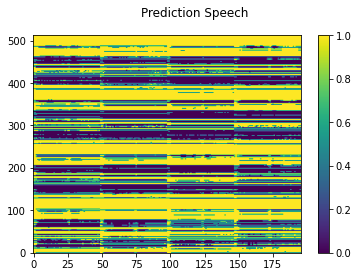

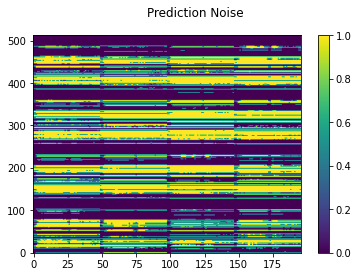

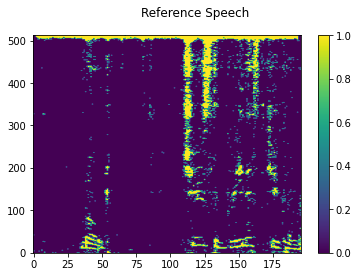

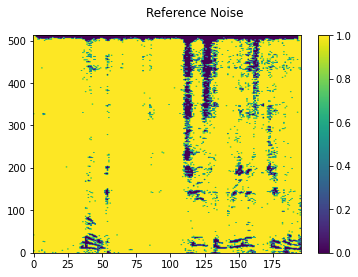

In [19]:
X = X.cpu()
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])>0.15).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y[e_nr][0], title="Reference Speech")
    plot_mask(Y[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(2001)

In [16]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)

def evaluateSiSNR(wave, i):
    def si_snr(estimate, reference, epsilon=1e-8):
        estimate = estimate - estimate.mean()
        reference = reference - reference.mean()
        reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
        mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
        scale = mix_pow / (reference_pow + epsilon)

        reference = scale * reference
        error = estimate - reference

        reference_pow = reference.pow(2)
        error_pow = error.pow(2)

        reference_pow = reference_pow.mean(axis=1)
        error_pow = error_pow.mean(axis=1)

        si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
        return si_snr.item()
    score = si_snr(wave, speech[i])
    #print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/model_out.wav",wave.reshape(1,-1),16000)

index = 2017
speech_pred = (model(X[index])>0.2).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
print(wave.shape)
print(wave)
save_sample(index, wave=wave)
score = evaluateSiSNR(wave,index)#Should be ~28
print(f"Si-SNR score: {score}")

torch.Size([50000])
tensor([0.0028, 0.0037, 0.0040,  ..., 0.0015, 0.0026, 0.0017])
Si-SNR score: 26.31098175048828


In [1]:
# Test Set
scores = []
for index in range(2000,2703):
    speech_pred = (model(X[index])>0.2).float()
    noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
    wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
    scores.append(evaluateSiSNR(wave,index))

np.mean(scores)

NameError: name 'model' is not defined